=== feature selection ===
# training accuracy: 0.7707006369426752
# test accuracy: 0.7553648068669528
# Feature selection result:
soft-encoding-aggregate
soft-aggregate-count
soft-encoding-type_quantitative
soft-encoding-non_positional_pref
soft-mark_type-d_d_point
soft-encoding-encoding_field
soft-scale-zero
=== training with full data ===
20 0.7173295454545454
25 0.7286931818181818
30 0.7528409090909091
35 0.7428977272727273
40 0.71875
45 0.7443181818181818
50 0.7627840909090909
55 0.7457386363636364
60 0.7784090909090909
65 0.7883522727272727
70 0.8153409090909091
75 0.8153409090909091
80 0.8323863636363636
85 0.8565340909090909
90 0.8664772727272727
95 0.8707386363636364
100 0.8522727272727273
105 0.875
110 0.8835227272727273
115 0.8821022727272727
120 0.8892045454545454
125 0.9048295454545454
130 0.9190340909090909
135 0.9147727272727273
140 0.9176136363636364
145 0.9303977272727273
150 0.9247159090909091
155 0.9247159090909091
160 0.9332386363636364
165 0.9403409090909091
170 0.9

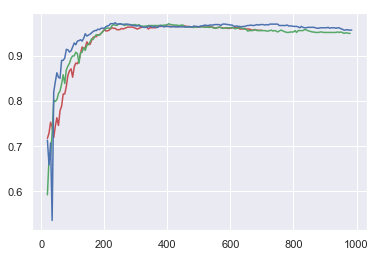

In [38]:
%matplotlib inline
import json
from pprint import pprint
import copy
import sys

import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel

# use seaborn plotting defaults
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

colors = ["r", "g", "b", "orange"]

def get_feature(vis):
    """Given a vis json object, parse its feature """
    def parse_soft_rule(rule):
        head = rule[:rule.index("(")]
        body = rule[rule.index("(") + 1: rule.index(")", -1)]
        literals = body.strip().split(",")
        return head, literals

    draco_facts = vis["draco"]
    if not isinstance(vis["draco"], (list,)):
        draco_facts = json.loads(vis["draco"])
    
    facts = [x for x in draco_facts if x.startswith("soft")]
    feature = {}
    for r in facts:
        h, l = parse_soft_rule(r)
        if len(l) > 1:
            rname = h + "-" + l[0] + "-" + l[1]
        else:
            rname = h + "-" + l[0]
        if rname not in feature:
            feature[rname] = 0
        feature[rname] += 1
        
    return feature

def get_pair_feature(pair):
    """Get the feature of a pair that will be used in active learning"""
    # flip the <, >
    flip = np.random.choice([0, 1])    
    if pair["comparator"] not in [">", "<"]:
        return None, None
    label = -1 if pair["comparator"] == "<" else 1
    left_facts = get_feature(pair["left"])
    right_facts = get_feature(pair["right"])
    combined = copy.copy(left_facts)
    for k, v in right_facts.items():
        if k not in combined:
            combined[k] = 0
        combined[k] -= v
    if flip == 1:
        for k, v in combined.items():
            combined[k] = -v
        label = -label
    return combined, label

def plot_svc_decision_function(model, ax=None, plot_support=False):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    
def train_and_eval(model, X, y, test_split=0.33, all_features= None):
    """train and eval the model using data X, y"""
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)    
    model.fit(X_train, y_train)
    
    print("# training accuracy: {}".format(model.score(X_train, y_train)))
    print("# test accuracy: {}".format(model.score(X_test, y_test)))
    
    print("# Feature selection result:")
    model = SelectFromModel(model, prefit=True)
    X = model.transform(X)
    if all_features is not None:
        for mask, f in zip(model.get_support(), all_features):
            if mask:
                print(f)


def active_learn(raw_model, X_train, y_train, X_test, y_test, sample_func="entropy"):
    """active learning loop"""
    
    model = CalibratedClassifierCV(raw_model, cv=5)
        
    X_label, X_pool = X_train[:20], X_train[20:]
    y_label, y_pool = y_train[:20], y_train[20:]
        
    X_label, y_label = list(X_label), list(y_label)
    X_pool, y_pool = list(X_pool), list(y_pool)
    
    sample_size = 5
    
    train_size = []
    acc_list = []
    while len(X_pool) > 0:
        model.fit(X_label, y_label)
        
        acc = model.score(X_test, y_test)
        acc_list.append(acc)
        train_size.append(len(X_label))
        
        # different sample function to obtain new data
        if sample_func == "entropy":
            # entropy based sampling
            prob_vals = model.predict_proba(X_pool)
            entropy_uncertainty = (-prob_vals * np.log2(prob_vals)).sum(axis=1)
            selections = (np.argsort(entropy_uncertainty)[::-1])[:sample_size]
        elif sample_func == "margin":
            # entropy based sampling
            prob_vals = model.predict_proba(X_pool)
            rev = np.sort(prob_vals, axis=1)[:, ::-1]
            values = rev[:, 0] - rev[:, 1]
            selections = np.argsort(values)[:sample_size]
        elif sample_func == "random":
            selections = np.random.choice(list(range(len(X_pool))), sample_size)

        X_label = X_label + [v for i,v in enumerate(X_pool) if i in selections]
        y_label = y_label + [v for i,v in enumerate(y_pool) if i in selections]
        
        X_pool = [v for i,v in enumerate(X_pool) if i not in selections]
        y_pool = [v for i,v in enumerate(y_pool) if i not in selections]
    
    plt.plot(train_size, acc_list, colors[0])
    colors.pop(0)
    
    for x, y in zip(train_size, acc_list):
        print(x, y)
        if x > 500:
            break
            
def load_pairs_from_file(fname, pair_limit):
    with open(fname, "r") as f:
        pairs = json.load(f)
        pairs = pairs[:pair_limit if len(pairs) > pair_limit else len(pairs)]
        data = []
        for p in pairs:
            feature, label = get_pair_feature(p)
            if feature is None:
                continue
            data.append((feature, label))
    return data
        

def eval_active_learn(datafile, test_datafile=None, maximum_pairs_used=5000):
        
    data = load_pairs_from_file(datafile, maximum_pairs_used)
    all_features = list(set([k for p in data for k in p[0].keys()]))
    
    X_test, y_test = None, None
    if test_datafile is not None:
        test_data = load_pairs_from_file(test_datafile, pair_limit=99999999)
        all_features = list(set([k for p in data + test_data for k in p[0].keys()]))
        X_test = np.array([[(p[0][feature_name] if feature_name in p[0] else 0) 
                    for feature_name in all_features] for p in data])
        y_test = np.array([p[1] for p in data])
    
    X = np.array([[(p[0][feature_name] if feature_name in p[0] else 0) 
                    for feature_name in all_features] for p in data])
    y = np.array([p[1] for p in data])        

    if X_test is None or y_test is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
    else:
        X_train, y_train = X, y

    print("=== feature selection ===")
    model = LinearSVC(fit_intercept=0,C=0.01, penalty="l1", dual=False)
    train_and_eval(model, X, y, test_split=0.33, all_features=all_features)

    print("=== training with full data ===")
    # training with the full data
    model = LinearSVC(fit_intercept=0)
    #train_and_eval(model, X, y)
    active_learn(model, X_train, y_train, X_test, y_test, sample_func="entropy")
    #active_learn(model, X_train, y_train, X_test, y_test, sample_func="random")

    
    
np.random.seed(9984)
#eval_active_learn("pairs.json")
#eval_active_learn("kimpairs.json")
eval_active_learn("test-splits/chunk_0.json", "test-splits/chunk_4.json", maximum_pairs_used=1000)
eval_active_learn("struct_labeled_pairs_no_min.json", "test-splits/chunk_4.json", maximum_pairs_used=1000)
eval_active_learn("struct_labeled_pairs.json", "test-splits/chunk_4.json", maximum_pairs_used=1000)
plt.show()

In [ ]:
# dataset = []
# labels = []

# with open("pairs.json", "r") as f:
#     pairs = json.load(f)
#     for i, p in enumerate(pairs):
#         dataset.append({
#             "id": i,
#             "left": p["left"]["draco"],
#             "right": p["right"]["draco"]
#         })
#         labels.append({
#             "id": i,
#             "label": p["comparator"]
#         })

# print(dataset[0])
# print(labels[0])

# with open("dataset.json", "w") as f:
#     json.dump(dataset, f, indent=4)

# with open("labels.json", "w") as f:
#     json.dump(labels, f, indent=4)